In [1]:
#!/usr/bin/python
# -*- coding: utf-8 -*-
import sys
import math
from typing import List, Tuple
from collections import namedtuple
import matplotlib.pyplot as plt
import random
from tqdm.notebook import tqdm
from itertools import product
from mip import Model, xsum, minimize, OptimizationStatus, VarList, SearchEmphasis, ConstrsGenerator, CutPool
import datetime
from random import shuffle
import networkx as nx

plt.rcParams['figure.figsize'] = [18, 13]

In [2]:
Point = namedtuple("Point", ['x', 'y'])

def length(point1, point2):
    return math.sqrt((point1.x - point2.x)**2 + (point1.y - point2.y)**2)

def sol_plot(solution,points):
    nodeCount=len(points)
    # plot the solution
    j=0
    for i in points:
        plt.plot(i.x, i.y,'ko')
        #plt.annotate(j,(i.x, i.y))
        j=j+1
    
    for i in range(-1, nodeCount-1):
        plt.plot((points[solution[i]].x, points[solution[i+1]].x),
                 (points[solution[i]].y, points[solution[i+1]].y),'-')
        
def objec(solution,points,d_m):
    nodeCount=len(points)
    obj = d_m[solution[-1]][solution[0]]
    for index in range(0, nodeCount-1):
        obj += d_m[solution[index]][solution[index+1]]
    return obj

def idx_two_opt(sol, idx1, idx2):
    # makes the reversal 
    if idx1<idx2:
        sol1=sol[:idx1]
        sol2=list(reversed(sol[idx1:idx2+1]))
        sol3=sol[idx2+1:]
    else:
        sol1=sol[:idx2]
        sol2=list(reversed(sol[idx2:idx1+1]))
        sol3=sol[idx1+1:]
    new_sol=sol1+sol2+sol3
    return new_sol
        
def two_opt_search(sol,points,d_m):
    nodeCount=len(points)
    best_sol=sol
    best_obj=objec(sol,points,d_m)
    for i in tqdm(range(nodeCount)):
            for j in range(nodeCount):
                p_sol=idx_two_opt(best_sol,i,j)
                p_obj=objec(p_sol,points,d_m)
                if p_obj<best_obj:
                    best_sol=p_sol
                    best_obj=p_obj
    return best_sol
        
#def SubTourDetector(x, nodes):
 #   sol= [0]
  #  rem_nodes = nodes
   # c_node=0
    #for j in range(nodeCount-1):
     #   for i in range(nodeCount):
      #      if round(m.var_by_name("x{}_{}".format(c_node,i)).x) != 0:
       #         sol.append(i)
        #        c_node=i
         #       break

        
class SubTourCutGenerator(ConstrsGenerator):
    """Class to generate cutting planes for the TSP"""
    def __init__(self, Fl: List[Tuple[int, int]], x_, V_):
        self.F, self.x, self.V = Fl, x_, V_

    def generate_constrs(self, model: Model, depth: int = 0, npass: int = 0):
        xf, V_, cp, G = model.translate(self.x), self.V, CutPool(), nx.DiGraph()
        for (u, v) in [(k, l) for (k, l) in product(V_, V_) if k != l and xf[k][l]]:
            G.add_edge(u, v, capacity=xf[u][v].x)
        for (u, v) in self.F:
            val, (S, NS) = nx.minimum_cut(G, u, v)
            if val <= 0.99:
                aInS = [(xf[i][j], xf[i][j].x)
                        for (i, j) in product(V_, V_) if i != j and xf[i][j] and i in S and j in S]
                if sum(f for v, f in aInS) >= (len(S)-1)+1e-4:
                    cut = xsum(1.0*v for v, fm in aInS) <= len(S)-1
                    cp.add(cut)
                    if len(cp.cuts) > 256:
                        for cut in cp.cuts:
                            model += cut
                        return
        for cut in cp.cuts:
            model += cut        

def tsp_mip_solver(input_data):
    # parse the input
    lines = input_data.split('\n')

    nodeCount = int(lines[0])

    points = []
    for i in range(1, nodeCount+1):
        line = lines[i]
        parts = line.split()
        points.append(Point(float(parts[0]), float(parts[1])))
    print('Points parsed!')
    
    # calculate distance matrix
    d_m = [ [length(q,p) for q in points] for p in points]
    print('Distance matrix ready!')
    
    # declare MIP model
    m = Model(solver_name='GRB')
    print('-Model instatiated!',datetime.datetime.now())
    
    # states search emphasis
    #     - '0' (default) balanced approach
    #     - '1' (feasibility) aggressively searches for feasible solutions
    #     - '2' (optimality) explores search space to tighten dual gap
    m.emphasis = 1
    
    # whenever the distance of the lower and upper bounds is less or 
    # equal max_gap*100%, the search can be finished
    m.max_gap = 0.05
    
    # specifies number of used threads
    # 0 uses solver default configuration, 
    # -1 uses the number of available processing cores 
    # ≥1 uses the specified number of threads. 
    # An increased number of threads may improve the solution time but also increases 
    # the memory consumption. Each thread needs to store a different model instance!
    m.threads = -1
    
    
    # controls the generation of cutting planes
    # cutting planes usually improve the LP relaxation bound but also make the solution time of the LP relaxation larger
    # -1 means automatic
    #  0 disables completely
    #  1 (default) generates cutting planes in a moderate way
    #  2 generates cutting planes aggressively
    #  3 generates even more cutting planes
    m.cuts=3
    
    m.preprocess=1
    m.pump_passes=10
    m.sol_pool_size=1
    
    # defining nodes as a set
    nodes = set(range(nodeCount))
    
    # defining possible transitions from node to node
    arcs = [(i, j) for (i, j) in product(nodes, nodes) if i != j]
    
    
    # instantiate "entering and leaving" variables
    x = [ [m.add_var(name="x{}_{}".format(p,q),var_type='B') for q in nodes] for p in nodes ] 
    # instantiate subtour elimination variables 
    y = [ m.add_var(name="y{}".format(i)) for i in nodes ]
    print('-Variables instantiated',datetime.datetime.now())
    
    # declare objective function
    m.objective = minimize( xsum( d_m[i][j]*x[i][j] for i in nodes for j in nodes) )
    
    print('-Objective declared!',datetime.datetime.now())
    
    # declare constraints
    # leave each city only once
    for i in nodes:
        m.add_constr( xsum(x[i][j] for j in nodes - {i}) == 1 )

    # enter each city only once
    for i in nodes:
        m.add_constr( xsum(x[j][i] for j in nodes - {i}) == 1 )
    
    # weak subtour elimination constraints
    for (i, j) in tqdm(product(nodes - {0}, nodes - {0})):
        if i != j:
            m.add_constr( y[i] - (nodeCount+1)*x[i][j] >= y[j]-nodeCount )
            
    # size 2 subtour elimination constraints
    for (i, j) in arcs:
            m.add_constr( x[i][j] + x[j][i] <= 1 )
            
            
            
    print('-Constraints declared!',datetime.datetime.now())
    
    #Maximum time in seconds that the search can go on if a feasible solution 
    #is available and it is not being improved
    mssi = 1000 #default = inf
    # specifies maximum number of nodes to be explored in the search tree (default = inf)
    mn = 100000 #default = 1073741824
    # optimize model m within a processing time limit of 'ms' seconds
    ms = 3000 #default = inf
    
    S=[i for i in range(nodeCount)]
    n_it = 5
    thld = 0.99
    obj = objec(S,points,d_m)
    for i in range(n_it):
        print('Two opt it ({}/{})'.format(i+1,n_it))
        s_obj = obj
        S = two_opt_search(S,points,d_m)
        obj=objec(S,points,d_m)
        print('S obj = {} / F obj = {}'.format(s_obj,obj))
        if obj/s_obj >= thld:
            print('No significant improvement, breaking.')
            break
            
    # warm start with best 2-opt solution
    m.start = [(x[S[k-1]][S[k]], 1.0) for k in range(nodeCount)]
    
    # computing farthest point for each point, these will be checked first for
    # isolated subtours
    F, G = [], nx.DiGraph()
    for (i, j) in arcs:
        G.add_edge(i, j, weight=d_m[i][j])
    for i in nodes:
        P, D = nx.dijkstra_predecessor_and_distance(G, source=i)
        DS = list(D.items())
        DS.sort(key=lambda x: x[1])
        F.append((i, DS[-1][0]))
    
    # sets up the cut generator
    m.cuts_generator = SubTourCutGenerator(F, x, nodes)
    
    # executes the optimization
    print('-Optimizer start.',datetime.datetime.now())
    status = m.optimize(max_seconds = ms)

    print('Opt. Status:',status)
    print('MIP Sol. Obj.:',m.objective_value)
    print('Dual Bound:',m.objective_bound)
    print('Dual gap:',m.gap)
    
    sol= [0]
    c_node=0
    for j in range(nodeCount-1):
        for i in range(nodeCount):
            if round(m.var_by_name("x{}_{}".format(c_node,i)).x) != 0:
                sol.append(i)
                c_node=i
                break
    print(sol)
    
    
    sol_plot(sol,points)
    obj=m.objective_value
    
    # prepare the solution in the specified output format
    if status == OptimizationStatus.OPTIMAL:
        output_data = '%.2f' % obj + ' ' + str(1) + '\n'
        output_data += ' '.join(map(str, sol))
    elif status == OptimizationStatus.FEASIBLE:
        output_data = '%.2f' % obj + ' ' + str(0) + '\n'
        output_data += ' '.join(map(str, sol))

    return output_data

gurobi version 9.0 found


Points parsed!
Distance matrix ready!
-Model instatiated! 2020-08-11 13:03:18.223454
-Variables instantiated 2020-08-11 13:03:18.235453
-Objective declared! 2020-08-11 13:03:18.262473



-Constraints declared! 2020-08-11 13:03:18.459632
Two opt it (1/5)



S obj = 1313.4683444443458 / F obj = 450.07991273626766
Two opt it (2/5)



S obj = 450.07991273626766 / F obj = 446.9951383678852
No significant improvement, breaking.
-Optimizer start. 2020-08-11 13:03:18.695780
Opt. Status: OptimizationStatus.OPTIMAL
MIP Sol. Obj.: 428.87175639203394
Dual Bound: 428.87175639203394
Dual gap: 0.0
[0, 33, 47, 26, 6, 36, 12, 30, 11, 42, 29, 43, 21, 37, 20, 25, 1, 31, 22, 48, 32, 17, 49, 39, 50, 38, 15, 14, 44, 16, 18, 40, 19, 7, 13, 35, 23, 34, 4, 8, 46, 24, 41, 27, 3, 45, 9, 10, 28, 2, 5]
428.87 1
0 33 47 26 6 36 12 30 11 42 29 43 21 37 20 25 1 31 22 48 32 17 49 39 50 38 15 14 44 16 18 40 19 7 13 35 23 34 4 8 46 24 41 27 3 45 9 10 28 2 5


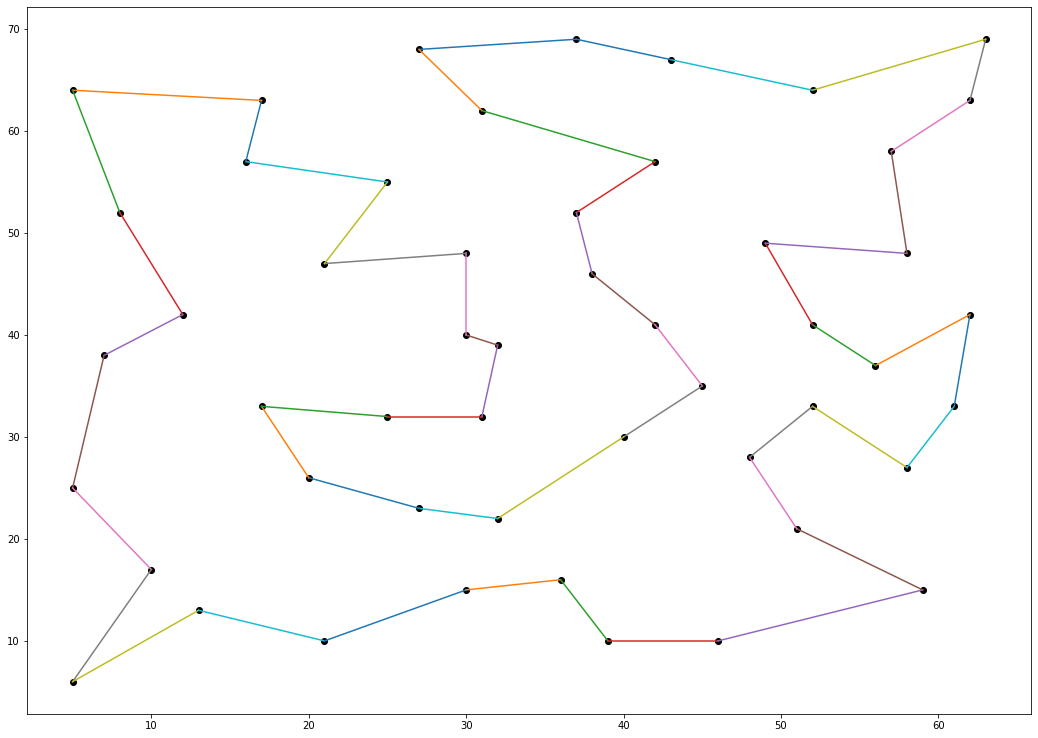

In [3]:
import os
notebook_path = os.path.abspath("Notebook.ipynb")
data_path = os.path.join(os.path.dirname(notebook_path), "data\\tsp_51_1")

if len(data_path) > 1:
    file_location = data_path.strip()
    with open(file_location, 'r') as input_data_file:
        input_data = input_data_file.read()
        print(tsp_mip_solver(input_data))
